<a href="https://colab.research.google.com/github/bhomaidan1990/SSI_Project/blob/master/MultiClass_Segmentation_SSI_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiClass Segmentation using pretrained model

### Import necssary libraries

In [1]:
!pip install segmentation_models
#----------------------------------
import random
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## Mount Google Drive to read Dataset

In [2]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


### Initialization

In [8]:
#--------------------------------------
# For reproducabilty
seed = 42
np.random.seed = seed
tf.random.set_seed = seed
#--------------------------------------
# Check if there is valid GPU to be used
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('GPU is Availabele cool...')
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    print('Warning ... you are working on CPU, it will take ages!')
#--------------------------------------
BACKBONE = 'resnet34'
#BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)

GPU is Availabele cool...


### Loading the Data

In [6]:
# load your data
# Path

images_Path = 'drive/My Drive/Dataset/Sample_Dataset/images/'
masks_Path = 'drive/My Drive/Dataset/Sample_Dataset/masks/'
test_Path  = 'drive/My Drive/Dataset/Sample_Dataset/test/'
masks_test_Path = 'drive/My Drive/Dataset/Sample_Dataset/mask_test/'

# List of files
#-------------------------------
images = os.listdir(images_Path)
masks = os.listdir(masks_Path)
test = os.listdir(test_Path)
masks_test = os.listdir(masks_test_Path)
#----------------------
IMG_Width  = 256
IMG_Height = 256
IMG_Channels = 1
#----------------------
def OneHotEncoding(im,n_classes):
  one_hot = np.zeros((im.shape[0], im.shape[1], n_classes))
  for i, unique_value in enumerate(np.unique(im)):
    one_hot[:, :, i][im == unique_value] = 1
  return one_hot
#----------------------
X = np.zeros((len(images),IMG_Height,IMG_Width,IMG_Channels),dtype=np.uint8)
Y = np.zeros((len(masks),IMG_Height,IMG_Width,4),dtype=np.uint8)
X_test = np.zeros((len(test),IMG_Height,IMG_Width,IMG_Channels),dtype=np.uint8)
Y_test = np.zeros((len(masks_test),IMG_Height,IMG_Width,4),dtype=np.uint8)

for n, id_ in tqdm(enumerate(images), total=len(images)):   
    img = imread(images_Path + id_)  
    X[n][:,:,0] = img  #Fill empty X_train with values from img
    mask = imread(masks_Path+ id_)
    mask = OneHotEncoding(mask,4)   
    Y[n][:,:,:] = mask #Fill empty Y_train with values from mask
# Y = tf.keras.utils.to_categorical(Y, num_classes=4, dtype="uint8")

for n, id_2 in tqdm(enumerate(test), total=len(test)):   
    img = imread(test_Path + id_2)  
    X_test[n][:,:,0] = img  #Fill empty X_train with values from img
    mask2 = imread(masks_test_Path+ id_2) 
    mask2 = OneHotEncoding(mask2,4)  
    Y_test[n][:,:,:] = mask2 #Fill empty Y_train with values from mask

# Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=4, dtype="uint8")
# one channel to 3 channels
# X = np.stack([X,X,X],axis=2)  
# Y = np.stack([Y,Y,Y],axis=2)
# X_test = np.stack([X_test,X_test,X_test],axis=2) 

# Split Train Test Validate
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)
# X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=0.1, random_state=42)
print('\nData Rreading, and Splitting Done!\n')
#----------------------------------------------------------------------------------------

100%|██████████| 10/10 [00:00<00:00, 136.29it/s]


Data Rreading, and Splitting Done!



### PreProcess the input, and define the model

In [10]:
# preprocess input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# define model
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.metrics import iou_score
from keras.layers import Input, Conv2D
from keras.models import Model

# define number of channels
N = X.shape[-1]

base_model = Unet(BACKBONE, classes=4, activation='softmax',
    encoder_weights='imagenet', encoder_freeze=False)
# ---------------------------------------------------------------
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)

# continue with usual steps: compile, fit, etc..
#----------------------------------------------------------------
# Loss


# loss = sm.losses.CategoricalCELoss()
loss = sm.losses.CategoricalFocalLoss()
opt = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)
# Compile Model
model.compile(
    opt,
    loss=loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)],
)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     6         
_________________________________________________________________
model_4 (Model)              (None, None, None, 4)     24456589  
Total params: 24,456,595
Trainable params: 24,439,245
Non-trainable params: 17,350
_________________________________________________________________


### fit model
if you use data generator use `model.fit_generator(...)` instead of `model.fit(...)` 

more about `fit_generator` [here](https://keras.io/models/sequential/#fit_generator)

In [14]:
# import keras
# Model Checkpoint
# Callbacks = [
#              keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'),
             
#              keras.callbacks.ModelCheckpoint('Model.h5',
#               verbose=1, save_best_only=True) # monitor = 'val_acc', mode = 'auto',
#              ]# keras.callbacks.TensorBoard(log_dir='logs'),
             
history = model.fit(
   x=X_train,
   y=Y_train,
   batch_size=8,
   epochs=100,
   validation_data=(X_val, Y_val),
)

# Evaluate Model
#================
score = model.evaluate(X_test, Y_test, batch_size=8)
print('Test loss:', score[0])
print('Test accuracy', score[1])
#------------------------------------------------------
# Save Model
#================
model.save('my_model.h5')
# Delete Model
del model

Train on 34 samples, validate on 6 samples
Epoch 1/100
34/34 [==============================] - 2s 67ms/step - loss: 0.0019 - iou_score: 0.7706 - f1-score: 0.8064 - val_loss: 0.0048 - val_iou_score: 0.5800 - val_f1-score: 0.6420
Epoch 2/100
34/34 [==============================] - 2s 67ms/step - loss: 0.0018 - iou_score: 0.8190 - f1-score: 0.8555 - val_loss: 0.0043 - val_iou_score: 0.6029 - val_f1-score: 0.6606
Epoch 3/100
34/34 [==============================] - 2s 68ms/step - loss: 0.0018 - iou_score: 0.7678 - f1-score: 0.8046 - val_loss: 0.0041 - val_iou_score: 0.6145 - val_f1-score: 0.6692
Epoch 4/100
34/34 [==============================] - 2s 67ms/step - loss: 0.0017 - iou_score: 0.8229 - f1-score: 0.8578 - val_loss: 0.0041 - val_iou_score: 0.5929 - val_f1-score: 0.6510
Epoch 5/100
34/34 [==============================] - 2s 67ms/step - loss: 0.0016 - iou_score: 0.8205 - f1-score: 0.8564 - val_loss: 0.0039 - val_iou_score: 0.6070 - val_f1-score: 0.6628
Epoch 6/100
34/34 [========

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### Visualize fitting curve

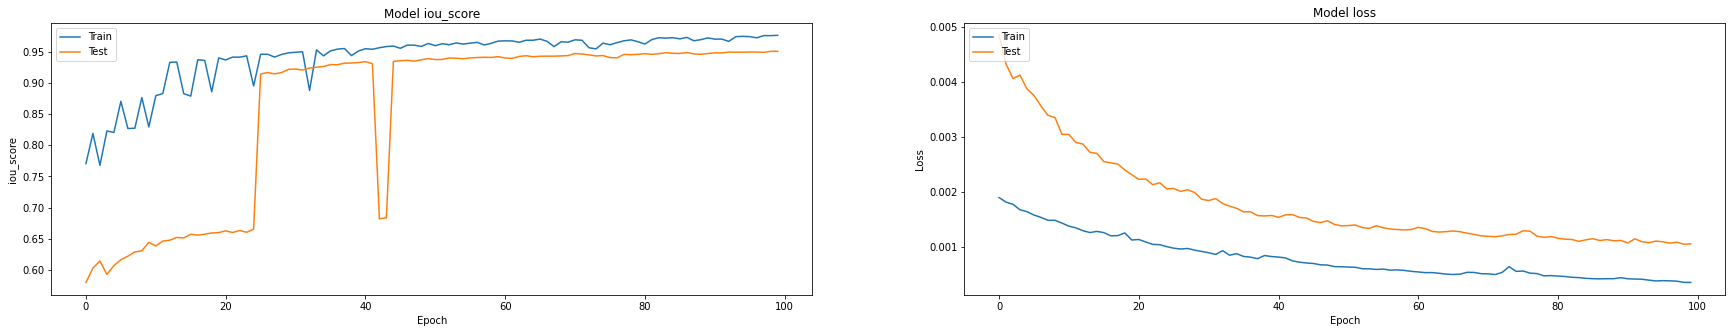

In [15]:
plt.figure(figsize=(30, 5), num = 'Metrics')
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Load Model

In [16]:
model = tf.keras.models.load_model("my_model.h5",compile=False)
model.compile( 'Adam',
    loss=loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
#
score = model.evaluate(X_test, Y_test, batch_size=100, verbose=1)
print('Test loss:', score[0])
print('Test accuracy', score[1])
#
prediction = model.predict(X_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0035 - iou_score: 0.8731 - f1-score: 0.9275
Test loss: 0.0034748632460832596
Test accuracy 0.8731422424316406


### Visualize the Results

0


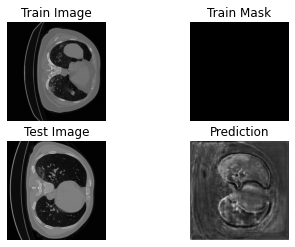

In [48]:
plt.figure(num='UNET Efficient Net B7')

plt.subplot('221')
plt.imshow(np.squeeze(X_train[30]),cmap='gray')
plt.title('Train Image')
plt.axis('off')

print(np.sum(Y_train[30][:,:,3]))

plt.subplot('222')
plt.imshow(Y_train[20][:,:,3],cmap='gray')
plt.title('Train Mask')
plt.axis('off')

plt.subplot('223')
plt.imshow(np.squeeze(X_test[9]),cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot('224')
plt.imshow(prediction[9][:,:,3],cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.show()